# Final assignment of “Management and Analysis of Physics Datasets” 
## Session II
### Anna Braghetto - 1205200 and Theosamuele Signor - 1212253

# Part A

Grid uses a network of resource-sharing commodity machines that permits to solve computational problem for which supercomputers and large cluster are needed. In particular its protocol architecture contains protocols and services at five layers: __fabric__, __connectivity__, __resource__, __collective__ and __application__.<br>



- The __fabric layer__ represents the resources: hardware for computation and storage, network and code repository. Grid uses existing fabric layer such as local resource managers, disk and tape managers.
- The __connectivity layer__ is responsible for easy and secure network transaction: it is a software layer with protocols for communication and authentication. In particular each transaction is defined by the GSI (Grid Security Infrastructure).
- The __resource layers__ is a software layer for protocols for: publication, discovery, negotiation, monitoring, accounting and payment of sharing operations on individual resources. 
- The __collective layer__ catches interactions across collection of resources. It offers services such as co-allocating, scheduling and brokering.
- The __application layer__ includes all the applications that are developed by the users operating in a VO.


Cloud is represented by computing and/or storage resources organized in large pool. Storages and resources can be accessed via standard protocols via an abstract interface. The Cloud architecture we consider is the 4-_layers_ version: __fabric__, __unified resource layer__, __platform__ and __application__. <br>

- The __fabric layer__ defines the raw hardware level resources: computation, storage and network.
- The __unified resource layer__ contains the abstracted resources, that usually have been virtualized in order to  be exposed to upper layer and to end users. For example the end users could be virtual computer or cluster, logical file system and database system.
- The __platform layer__ provides a development and deployment platform. To accomplish this task, the layer adds a collection of specialized tools, middleware and service on top of the unified resources.
- The __application layer__ contains all the applications that run in the Cloud.

Neverthless, both Grid and Cloud deal with distributed resources differs for many properties. 
At first the end users are different: Grid arises as a response to the need to analyze large amounts of scientific data, so it is exploited by universities and research centers such as Cern, while Cloud is the commercial response to Grid, so it is used by private companies such as Google, Microsoft and Amazon. 
Also the structure differs: the Grid resources are distributed over grids, while the Cloud ones are managed centrally.
For what concerns the layer, they share the fabric and application ones, in which the resources and applications are collected. The other layers differs as explained above. 

# Part B

At first, we import the required libraries.

In [1]:
#general
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#time
from timeit import default_timer as tic

#sklearn
import sklearn
from sklearn.datasets import make_classification
from sklearn.externals.joblib import parallel_backend
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

#dask
from dask.distributed import Client
import dask_ml.cluster
from dask import dataframe as dd
from dask import delayed
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import MinMaxScaler
from dask_ml.wrappers import ParallelPostFit
from dask_ml.wrappers import Incremental

import warnings
warnings.filterwarnings('ignore')

## 1. Cluster with 2 workers

We created a cluster with a fixed number of workers, equal to 2. The code below works as well for an arbitrary number of workers.

In [2]:
client = Client('10.190.1.25:8786')
client

Client Scheduler: tcp://10.190.1.25:8786 Dashboard: http://10.190.1.25:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.15 GB


We define the number of workers in order to save data.

In [3]:
#to save data for an arbitrary number of workers
workers = 2
store = True

## 2. Load the dataset

The dataset that we analysed contains information about handwritten characters of the English alphabet on an grayscale image whose dimension is 28x28 pixels. In particular, the first two columns decrescribes the label of the each image: the first one contains the letter as 'a','b' etc, while in the second one, the character labels are converted into numbers (in this way the letter 'a' has label 0 while 'b' correponds to 1, etc). The last columns, from the third to the end, contains the value of the each pixel in the image. 

We load the data as a Dask dataframe and we inspect the dimension.

In [4]:
#read the dataset from the remote link as a panda dataframe
data=dd.read_csv('https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1')

In [5]:
print('The number of rows is:', len(data))
print('The number of columns is:', data.shape[1])

The number of rows is: 50000
The number of columns is: 786


## 3. Count the number of examples for each alphabet character

The aim of this part is to count the frequency of each letter of the dataset.

At first, we define the function __partition()__ that permits to make a repartion of the orginal dataframe with arbitrary number of partitions, passed as argument of the function. For this first part, this number is fixed to 1. <br> Then, in order to count the number of examples for each alphabet character, we define the function __count()__ which takes in input the Dask dataframe and returns the list of the wanted counting. 

In [6]:
#create a data frame with different partitions
def partition(partition):
    return data.repartition(npartitions=partition)

#count the letters
def count(df):
    return df.groupby(['letter']).size().compute()

#### COUNT FOR ONE PARTITION

We show the count for one partition in a barplot.

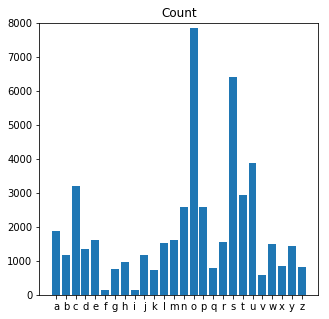

In [7]:
#plot for one partition
LCount = count(partition(1))

fig, ax = plt.subplots(figsize=(5,5))
ax.bar(np.arange(26), LCount.values)
ax.set_xticks(np.arange(26))
ax.set_xticklabels( LCount.index)
ax.set_ylim(top=8000)
ax.set_title("Count");

The most frequent letter is "o" with almost 8000 counts, while the least frequent one is "f" with less than 150 counts.

## 4. Record time and arbitrary number of partitions

In this part, we compute the needed time to perform the count for different number of partitions. In particular we consider 1, 2, 4, 6, 8, 10, 50 and 100 partitions. <br> To accomplish this task we define the function __CountTime()__ that store the needed time to perform the count for all the partitions and plot the result in a graph.


#### COUNT FOR MANY PARTITIONS

In [8]:
def CountTime():
    #define the partitions
    partitions = np.array([workers,20,40,60,80,100])
    #array for the times
    time = []

    for i in partitions:
        #creation of the dask dataframe with i partitions
        d = partition(i)
        t1 = tic()
        #apply the function count to the dataframe
        count(d)
        t2=tic()
        #store the needed time
        time.append(t2-t1)
        
    #plot for different partitions
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(partitions,time,'*-')
    ax.set_xlabel('Partitions ')
    ax.set_ylabel('Time (s)');
    
    return np.vstack((partitions,np.array(time)))

We call the function and save the data in a file.

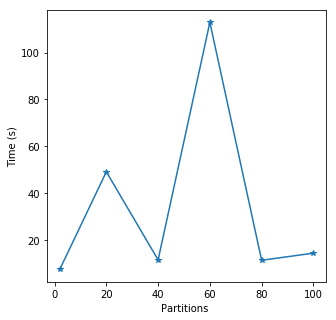

In [13]:
CT = CountTime()

In [14]:
if store:
    print('Store the results!')
    Out=pd.DataFrame(CT).T
    Out.to_csv('Partitions'+str(workers)+'.csv',index=None)

Store the results!


The results for different partitions are collected in the Table below. Since the values changes every time the function is called, the results are relative to the last call.

|Partions|Time (s)|
|--------|--------|
|2|7.57|
|20|49.17|
|40|11.6|
|60|112.85|
|80|11.48|
|100|14.51|


As shown in the graph and in the table, we observe that the time does not follow a particular trend, it is very random: we cannot know what the cluster actually does during the computation and this behaviour is reflected in the results, that in fact change at each call.
Moreover the dataset is too small to notice a clear improvement in performance.

Since the performance of the algorithm is not affected by the number of partitions we analysed, an optimal number does not exist. However, in order to expoit properly the workers, we set the number of partitions equal to the number of the latter.

## 5. Subsampling

In this part we prepare the dataset for a succeeding training of a single neural network that will classify the character 'a' and 'z' by knowing the values of their pixels. <br>
To accomplish this part, at first we need a dataset containing just the required charachters. Therefore we subsampled the dataset in order to have just rows for letters "a" and "z".

In [16]:
#dataset
d = partition(workers)

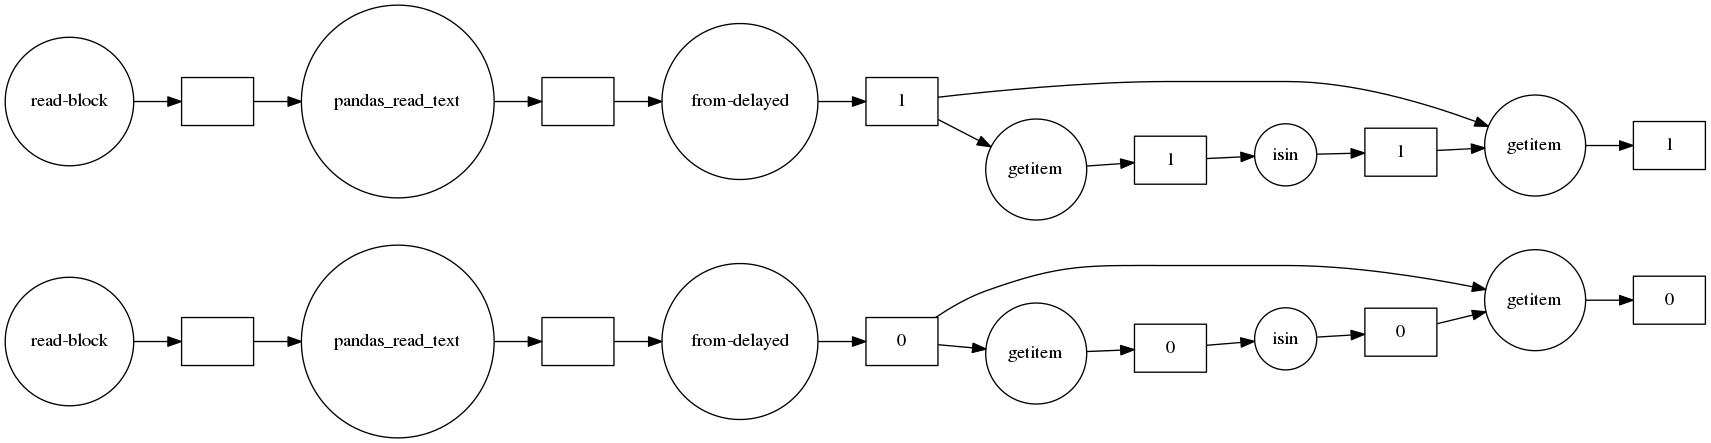

In [17]:
#filtering the data
letters = d[d['label'].isin([0, 25])]
display(letters.visualize(rankdir='LR'))

In the graph above we observe the two partitions: __0__ and __1__. For each partition the worker looks for an item ad checks, with _isin()_, if it has label "0" or "25". Then, if the character corresponds to the wanted ones, it is kept in the partion. As shown, the job is achivied in parallel for the two partitions.

## 6. Train and Test dataset

To study the performance of the neural network, we need to have a dataset on which train the latter and a dateset on which test it.<br>
Therefore, we divided the dataset into train and test sets. In particular we keep 80% as train data, i.e. the set on which we train our predictors and 20% as test data, i.e. the set on which we test our predictors. <br>
To accomplish this task, at first we divide the labels (Y) on the second columns, from the the value of the pixels, called features (X), contained from the third column to the end. Then, we split the set into train and test using the function provided by __dask_ml.model_selection__.

In [18]:
y = letters['label'].to_dask_array(lengths=True)
X = letters[letters.columns.difference(['label','letter'])].to_dask_array(lengths=True)

#divide into train and test
X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=0, test_size=0.2)

## 7. Training of the neural network

Our aim is to use the train data set to fit a simple neural network defined using an MLPClassifier. Then we predict on the test set and compute the accuracy.

At first we apply MinMaxScaler to scale the data in order to standardize them. In particular we fit the trasformer on the train set and we apply the fitted trasform both on the train and the test.

In [19]:
transformer = MinMaxScaler(feature_range=(0, 1), copy=True)

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

We define the estimator as MLPClassifier provided by __sklearn.neural_network__: we put a maximum number of iterations to 1000, two hidden layers with 200 neurons per each, the activation function of each neuron is the rectified linear unit function and the solver is the Adam gradient descent.

In [20]:
estimator = MLPClassifier(random_state=1234, 
                          max_iter=1000, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)

At the end we fit the neural network on the training set using the incremental learning. The incremental learning is usefull for huge dataset, for which the training is hard to perform: the fitting is performed on subsets, without using the whole dataset. 
To predict on our data we use the ParallelPostFit, which permits to predict by parallelizing the job.<br>
In particular we store the time needed for traininig and prediction, and the accuracy computed on the test set.

In [28]:
t1 = tic()
clf = Incremental(estimator)
clf.fit(X_train, y_train, classes=[0, 25])
clfP = ParallelPostFit(estimator=clf.estimator_,scoring='accuracy')
t2 = tic()

accuracy = dask_ml.metrics.accuracy_score(y_test, clfP.predict(X_test))
time = t2-t1

print("Accuracy: %0.2f "%accuracy)
print("Time: %0.2f"%time,"s")

Accuracy: 0.98 
Time: 11.16 s


The accuracy is very high, 98% of the characters are well classified. 

Below it is possible to save the data appending them on the same file in order to compare them for different workers.

In [29]:
if store: 
    print('Store the results!')
    with open('accuracies.txt', 'a') as acc:
        acc.write(str(workers) + '\t' + str(accuracy)+'\n')
    with open('times.txt', 'a') as tim:
        tim.write(str(workers) + '\t' + str(time)+'\n')

Store the results!


### 8. Comparison among different number of workers

It is possible to compare the results obtained using different workers.

#### Time for the count

At first we compare the times obtained to make the count for different number of partitions using different number of workers.
Below we plot the results.

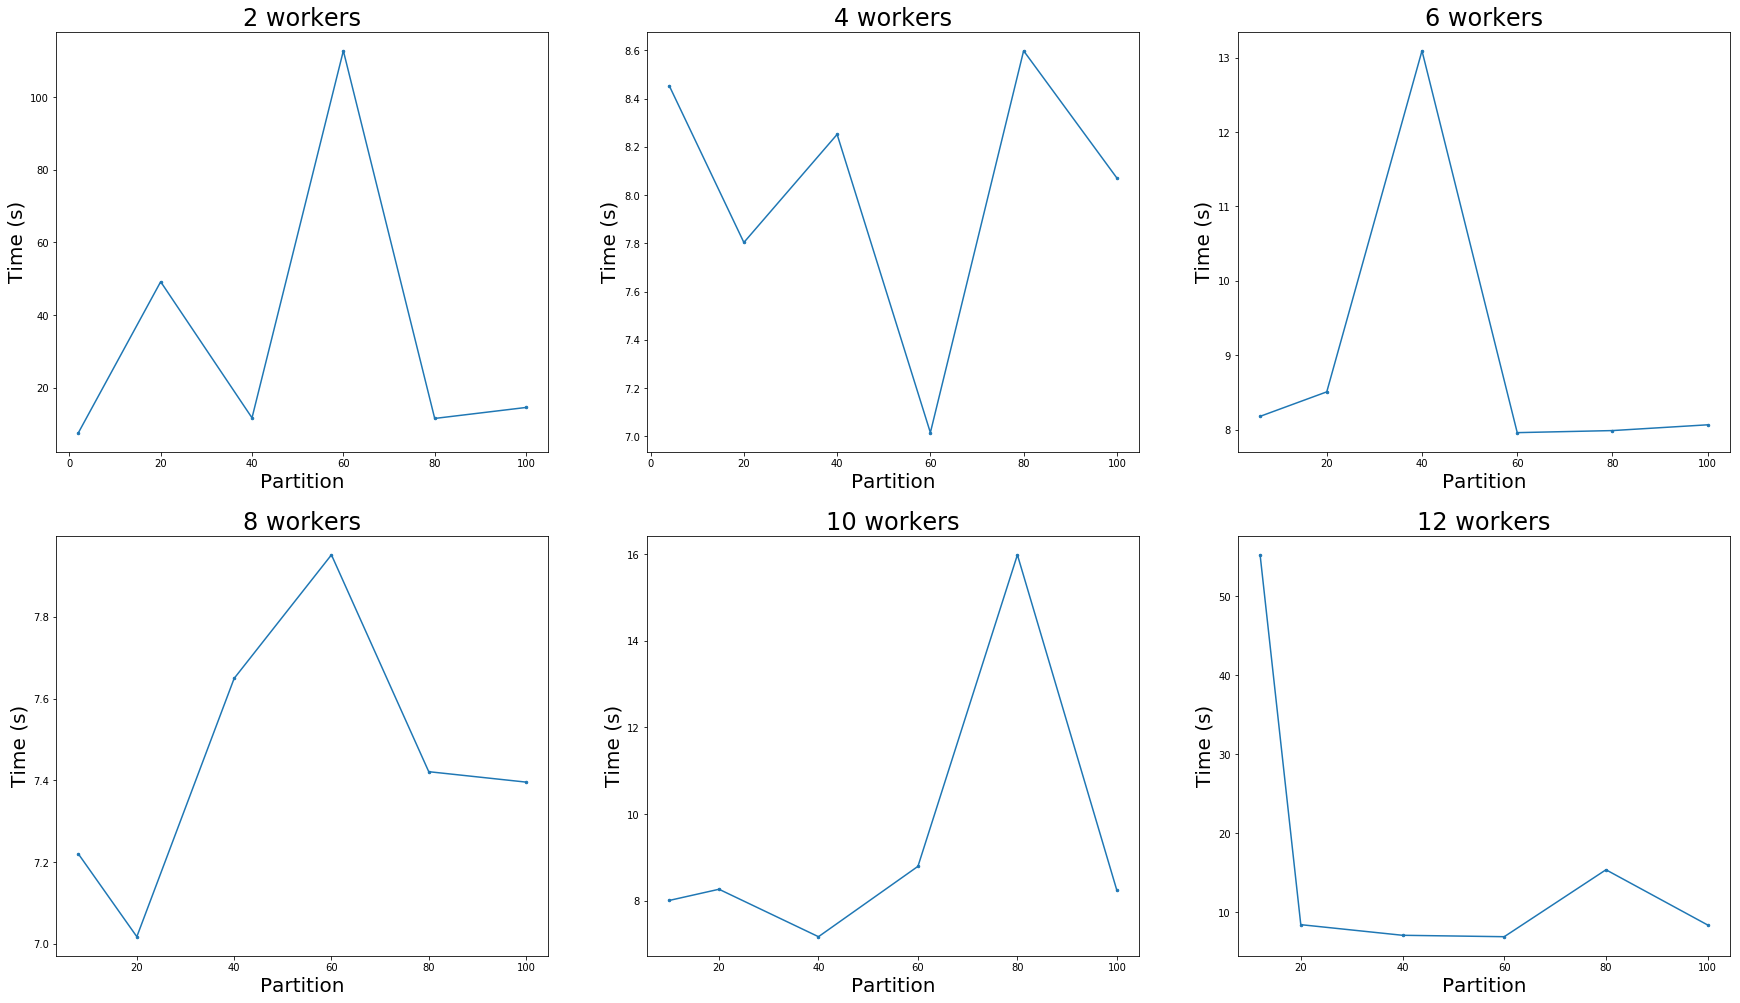

In [30]:
workers = [2,4,6,8,10,12]

(fig, subplots) = plt.subplots(2,3,figsize=(30,17))

for i in range(2):
    for j in range(3):
        w = i*3+j
        In = pd.read_csv('Partitions'+str(workers[w])+'.csv')
        ax = subplots[i][j]
        ax.set_title(str(workers[w])+' workers',fontsize=24)
        ax.plot(In['0'],In['1'],'.-',markersize=5)
        ax.set_xlabel('Partition',fontsize=20)
        ax.set_ylabel('Time (s)',fontsize=20);

As we already observed for the times obtained using just 2 workers, also for the others, the results are random and there are not trends on the behaviour. This is due to the fact that  we do not know how the cluster works during the computation and our dataset is really small ($\sim$ 80MB). For example, neverthless the scheduler tries to optimize the distribution of the partions to workers, we cannot know first how many partitions are associated to each worker.

#### Time for the train and test, and accuracy

Below we compare the results obtained for the time of train and test, and for the accuracy by using different number of workers.

In [31]:
Acc = np.genfromtxt('accuracies.txt')
Tim = np.genfromtxt('times.txt')

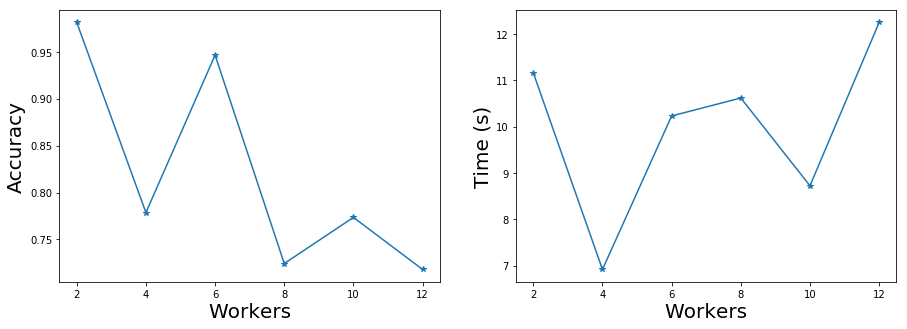

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(Acc[:,0],Acc[:,1],'*-')
ax1.set_ylabel('Accuracy',fontsize=20)
ax1.set_xlabel('Workers',fontsize=20)
ax2.plot(Tim[:,0],Tim[:,1],'*-')
ax2.set_ylabel('Time (s)',fontsize=20)
ax2.set_xlabel('Workers',fontsize=20);

As expected, the results, both for accuracy and time do not follow a particular trend because, as said above, we cannot know how the cluster works during the computation and the dataset is small.

### 9. TensorFlow

At first we import the required libraries.

Since the train and test data are already scaled we do not apply the MinMaxScaler again, so we just reshape the arrays before using them to train and test.

The CNN is built using dask_tensorflow and keras.

In [4]:
workers = 2

In [5]:
#keras
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Sequential

#sklearn
from sklearn.metrics import accuracy_score

#dask
from dask_tensorflow import start_tensorflow

Using TensorFlow backend.


In [6]:
tf_spec, dask_spec = start_tensorflow(client, ps=int(workers/2), worker=int(workers/2))

In [7]:
#read the dataset from the remote link as a dask dataframe
d=dd.read_csv('https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1')

In [8]:
#filtering the data
letters = d[d['label'].isin([0, 25])]

In [9]:
#X and y
y = letters['label'].values.compute()
y[y==25]=1
X = letters[letters.columns.difference(['label','letter'])].values.compute()

In [10]:
#divide into train and test
X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=0, test_size=0.2, train_size=0.8)

Mixture of types in 'arrays'. Falling back to scikit-learn.


In [11]:
#reshape
X_train, X_test = X_train.reshape((len(X_train), 28,28,1)),  X_test.reshape((len(X_test), 28,28,1))

In [12]:
def build_deep_cnn_neural_network():
    # create model 
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3,3), name='c', strides=(1, 1), padding='valid', activation='relu', input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', name='d'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name='d1'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', name='d2'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
#fit the model
t1 = tic()
model = build_deep_cnn_neural_network()
model.fit(X_train, y_train, verbose=1, epochs=10, batch_size=32)
#score
scores = model.evaluate(X_test,y_test, verbose=1)
t2= tic()
print("Accuracy: %0.2f"%scores[1])
print('Time:  %0.2f'%(t2-t1), 's')

Epoch 1/10
2161/2161 [==============================] - 6s 3ms/step - loss: 2.2470 - acc: 0.8515
Epoch 2/10
2161/2161 [==============================] - 5s 2ms/step - loss: 0.7001 - acc: 0.9551
Epoch 3/10
2161/2161 [==============================] - 5s 2ms/step - loss: 0.6043 - acc: 0.9616
Epoch 4/10
2161/2161 [==============================] - 5s 2ms/step - loss: 1.0739 - acc: 0.9329
Epoch 5/10
2161/2161 [==============================] - 5s 2ms/step - loss: 0.5014 - acc: 0.9676
Epoch 6/10
2161/2161 [==============================] - 5s 2ms/step - loss: 0.4382 - acc: 0.9722
Epoch 7/10
2161/2161 [==============================] - 5s 2ms/step - loss: 0.5909 - acc: 0.9630
Epoch 8/10
2161/2161 [==============================] - 5s 2ms/step - loss: 0.8070 - acc: 0.9491
Epoch 9/10
2161/2161 [==============================] - 5s 2ms/step - loss: 1.1790 - acc: 0.9260
Epoch 10/10
541/541 [==============================] - 0s 542us/step
Accuracy: 0.98
Time:  51.77 s


In [14]:
#store the results
if store: 
    print('Store the results!')
    with open('accuraciesCnn.txt', 'a') as acc:
        acc.write(str(workers) + '\t' + str(scores[1])+'\n')
    with open('timesCnn.txt', 'a') as acc:
        acc.write(str(workers) + '\t' + str(t2-t1)+'\n')

Store the results!


We compare the results obtaneid by using different workers.

In [16]:
Acc = np.genfromtxt('accuraciesCnn.txt')
Tim = np.genfromtxt('timesCnn.txt')

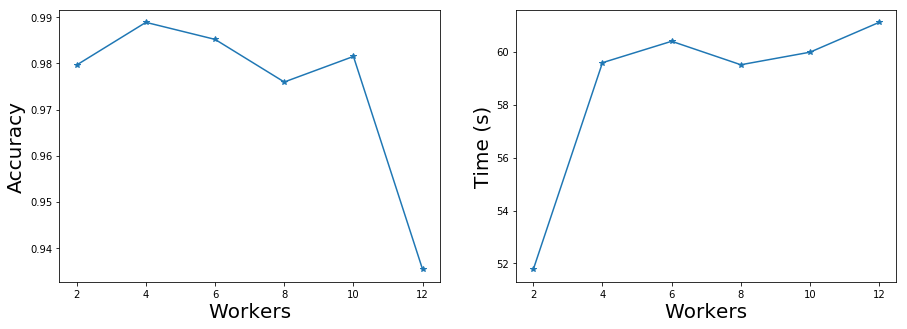

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(Acc[:,0],Acc[:,1],'*-')
ax1.set_ylabel('Accuracy',fontsize=20)
ax1.set_xlabel('Workers',fontsize=20)
ax2.plot(Tim[:,0],Tim[:,1],'*-')
ax2.set_ylabel('Time (s)',fontsize=20)
ax2.set_xlabel('Workers',fontsize=20);

As expected we observe an improvement on the accuracy: almost the accuracies are almost 1. This was predictable since the CNN is a better predictor to perform classification on images. 